# **Task 1: Next-Word Prediction using MLP**

This report details the implementation, training, and analysis of a Multi-Layer Perceptron (MLP) for next-word prediction on two distinct datasets: Shakespeare (Category I: Natural Language) and the Linux Kernel source code (Category II: Structured/Domain Text).

## **Training Pipeline**




## 1. Setup and Configuration

* **Device Selection**: The pipeline first checks if a CUDA-enabled GPU is available (`torch.cuda.is_available()`). If not, it defaults to the CPU and issues a warning. All models and data tensors are explicitly moved to this device.
* **Experiment Naming**: A unique `run_name` (e.g., `shakespeare_regularized`) is created based on the chosen dataset and whether regularization is enabled. This name is used for all output files (models, logs, plots) to keep experiments organized.

### 2. Data Loading and Preparation

* **Preprocessing**: The `download_and_preprocess_text` function is called to get the raw, clean text.
* **Tokenization & Pair Creation**: The `create_vocabulary_and_pairs` function tokenizes the text, builds the `word_to_idx` vocabulary (saving it to a JSON file), and most importantly, generates the `(context, target)` pairs. This creates our dataset by sliding a window of `context_size` words across the text, where the goal is to predict the word immediately-following the window.
* **Dataset Split**: The full dataset is split into an **80% training set** and a **20% validation set**. This split is crucial for monitoring overfitting.
* **DataLoaders**: PyTorch `DataLoader`s are created for both `train_dataset` and `val_dataset`. These are responsible for:
    * **Batching**: Grouping data into batches of size `args.batch_size`.
    * **Shuffling**: Randomizing the training data each epoch (`shuffle=True`) to prevent the model from learning the data's order.
    * **Performance**: Using `num_workers=4` and `pin_memory=True` to speed up data loading by using parallel processes and pre-loading data into GPU-pinned memory.

### 3. Model, Optimizer, and Loss

* **Model Initialization**: The `NextWordPredictor` model is instantiated with the correct `vocab_size`, `embedding_dim`, `context_size`, `hidden_dim`, and `use_dropout` flag. It's then moved to the active `device`.
* **Optimizer**: We use **AdamW** (`optim.AdamW`), a robust optimizer that is particularly effective when used with L2 regularization (weight decay). The L2 `weight_decay` is set to `1e-4` if regularization is on, and `0.0` otherwise.
* **Loss Function**: **Cross-Entropy Loss** (`nn.CrossEntropyLoss`) is used, which is standard for multi-class classification problems (where each word in the vocabulary is a class). We set `ignore_index=0` to ensure that any `<pad>` tokens in our data do not contribute to the loss calculation.

### 4. High-Performance Training Loop (AMP)

The code iterates for the specified number of `epochs`. For efficiency, this pipeline uses **Automatic Mixed Precision (AMP)**, which dramatically speeds up training on modern GPUs.

* `torch.cuda.amp.GradScaler`: This utility helps prevent numerical underflow issues that can arise when using half-precision (16-bit) floats during training.
* `with torch.cuda.amp.autocast()`: This context manager automatically casts operations to half-precision where safe, speeding up the forward pass and loss calculation.

#### **Per-Epoch Training (`model.train()`)**
1.  The model is put into training mode (`model.train()`), which enables dropout.
2.  The `optimizer.zero_grad()` call clears gradients from the previous batch.
3.  The `autocast` context runs the forward pass: `outputs = model(inputs)`.
4.  The loss is calculated: `loss = criterion(outputs, labels)`.
5.  **Backward Pass**:
    * `scaler.scale(loss).backward()`: The scaler scales the loss and performs backpropagation to compute the gradients.
    * `scaler.step(optimizer)`: The scaler unscales the gradients and instructs the optimizer to update the model weights.
    * `scaler.update()`: The scaler updates its scaling factor for the next iteration.

#### **Per-Epoch Validation (`model.eval()`)**
1.  The model is put into evaluation mode (`model.eval()`), which disables dropout. This ensures our validation results are deterministic.
2.  `with torch.no_grad()`: This context manager disables gradient calculation, which saves memory and computation since we are not training.
3.  The loop iterates over the `val_loader`, calculates the `avg_val_loss`, and reports both training and validation loss for the epoch.

### 5. Checkpointing (Model Saving)

* **Best Model**: After each epoch, the current `avg_val_loss` is compared to the `best_val_loss` seen so far. If the current loss is lower, the model's `state_dict` is saved to `{run_name}_model_best.pth`. This ensures we always keep the version of the model that performed best on the validation data.
* **Final Model**: After all epochs are complete, the final state of the model is saved to `{run_name}_model_latest.pth`.

### 6. Reporting and Visualization

Finally, the script saves two key artifacts:
1.  **Training History (`{run_name}_training_history.json`)**: A JSON file containing the train and validation loss for every epoch.
2.  **Loss Curve (`{run_name}_loss_curve.png`)**: A `matplotlib` plot showing the training and validation loss curves over time. A vertical dashed line indicates the epoch where the best model was saved, making it easy to visually diagnose overfitting.

In [ ]:

import os
import re
import json
import time
import argparse
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random

# --- Data Preprocessing ---

def download_and_preprocess_text(dataset_name):
    """Downloads and preprocesses the specified dataset."""
    if dataset_name == 'shakespeare':
        url = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'
        filename = 'shakespeare_input.txt'
        if not os.path.exists(filename):
            print(f"Downloading {filename}...")
            os.system(f"wget {url}")
        with open(filename, "r", encoding='utf-8') as f:
            text = f.read()
        text = re.sub(r'[^a-zA-Z0-9 \.]', '', text.lower())
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    elif dataset_name == 'linux':
        url = 'https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt'
        filename = 'linux_input.txt'
        if not os.path.exists(filename):
            print(f"Downloading {filename}...")
            os.system(f"wget {url}")
        with open(filename, "r", encoding='utf-8', errors='ignore') as f:
            text = f.read()
        lines = text.split('\n')
        processed_lines = []
        for line in lines:
            processed_line = re.sub(r'[^\w\s\.\(\)\[\]\{\}\=\+\-\*\/,;:"\'#<>&|!~`?]', '', line)
            processed_lines.append(processed_line.strip())
        return ' \n '.join(processed_lines)
    else:
        raise ValueError("Invalid dataset name. Choose 'shakespeare' or 'linux'.")

def create_vocabulary_and_pairs(text, context_window_size):
    """Creates vocabulary, reports frequencies, and generates context-target pairs."""
    print("Tokenizing text...")
    tokens = text.split(' ')
    tokens = [token for token in tokens if token]

    word_counts = Counter(tokens)
    print("\n--- Vocabulary Report ---")
    print(f"10 Most Frequent Words: {word_counts.most_common(10)}")
    print(f"10 Least Frequent Words: {word_counts.most_common()[:-11:-1]}")

    vocab = sorted(list(set(tokens)))
    word_to_idx = {word: i+1 for i, word in enumerate(vocab)}
    word_to_idx['<pad>'] = 0
    idx_to_word = {i: word for word, i in word_to_idx.items()}
    vocab_size = len(word_to_idx)
    print(f"Vocabulary Size: {vocab_size}")

    indexed_tokens = [word_to_idx[word] for word in tokens]
    contexts, targets = [], []
    for i in range(len(indexed_tokens) - context_window_size):
        contexts.append(indexed_tokens[i:i+context_window_size])
        targets.append(indexed_tokens[i+context_window_size])

    return torch.tensor(contexts, dtype=torch.long), torch.tensor(targets, dtype=torch.long), word_to_idx, idx_to_word

# --- Model Definition ---

class NextWordPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim, use_dropout=False):
        super().__init__()
        self.use_dropout = use_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        if self.use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x).view(x.size(0), -1)
        out = self.relu(self.fc1(embedded))
        if self.use_dropout:
            out = self.dropout(out)
        out = self.relu(self.fc2(out))
        if self.use_dropout:
            out = self.dropout(out)
        out = self.fc3(out)
        return out

# --- Main Training and Evaluation Function ---

def main(args):
    """Main training and evaluation function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if not torch.cuda.is_available():
        print("WARNING: CUDA not available, running on CPU.")

    file_suffix = "_regularized" if args.use_regularization else "_normal"
    run_name = f"{args.dataset}{file_suffix}"

    print(f"--- Starting Run: {run_name} on {device} ---")

    # --- 1. Data Loading and Preprocessing ---
    raw_text = download_and_preprocess_text(args.dataset)
    contexts, targets, word_to_idx, idx_to_word = create_vocabulary_and_pairs(raw_text, args.context_size)
    vocab_size = len(word_to_idx)

    with open(f'{run_name}_word_to_idx.json', 'w') as f:
        json.dump(word_to_idx, f)

    dataset = TensorDataset(contexts, targets)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, pin_memory=True, num_workers=4)

    # --- 2. Model, Optimizer, and Loss ---
    model = NextWordPredictor(
        vocab_size, args.embedding_dim, args.context_size, args.hidden_dim, use_dropout=args.use_regularization
    ).to(device)

    weight_decay_val = 1e-4 if args.use_regularization else 0.0
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=weight_decay_val)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    # --- 3. Training Loop ---
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')

    for epoch in range(args.epochs):
        model.train()
        total_train_loss = 0.0
        pbar_desc = f"Epoch {epoch+1}/{args.epochs} [{run_name} Train]"
        train_pbar = tqdm(train_loader, desc=pbar_desc)
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --- 4. Validation Loop ---
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            pbar_desc = f"Epoch {epoch+1}/{args.epochs} [{run_name} Val]"
            val_pbar = tqdm(val_loader, desc=pbar_desc)
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"[{run_name}] Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save the best performing model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'{run_name}_model_best.pth')
            print(f"[{run_name}] New best validation loss: {best_val_loss:.4f}. Saving best model.")

    # Save the final 500th epoch model
    torch.save(model.state_dict(), f'{run_name}_model_latest.pth')
    print(f"[{run_name}] Saved final model from epoch {args.epochs}.")

    print(f"--- [{run_name}] Training Complete ---")
    print(f"Final Best Validation Loss: {best_val_loss:.4f}")

    # --- 5. Reporting and Visualization ---
    history_path = f'{run_name}_training_history.json'
    with open(history_path, 'w') as f:
        json.dump(history, f)
    print(f"Training history saved to {history_path}")

    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    best_epoch = np.argmin(history['val_loss'])
    plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best Model (Epoch {best_epoch+1})')
    plt.title(f'Training vs. Validation Loss ({run_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{run_name}_loss_curve.png')
    print(f"Loss curve saved to {run_name}_loss_curve.png")

# --- Main Execution ---

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Single-GPU MLP Experiment Runner")
    # Experiment Setup
    parser.add_argument('--dataset', type=str, required=True, choices=['shakespeare', 'linux'], help='Dataset to use.')
    parser.add_argument('--use_regularization', action='store_true', help='Enable Dropout and L2 Weight Decay.')
    # Model Hyperparameters
    parser.add_argument('--context_size', type=int, default=5, help='Number of context words.')
    parser.add_argument('--embedding_dim', type=int, default=64, help='Dimension of word embeddings.')
    parser.add_argument('--hidden_dim', type=int, default=1024, help='Dimension of hidden layers.')
    # Training Hyperparameters
    parser.add_argument('--epochs', type=int, default=500, help='Number of training epochs.')
    parser.add_argument('--batch_size', type=int, default=40960, help='Batch size for training.')
    parser.add_argument('--lr', type=float, default=1e-3, help='Learning rate.')

    args = parser.parse_args()
    main(args)

###Configurations

In [ ]:
import os
from huggingface_hub import snapshot_download

# --- Configuration ---
# Your Hugging Face repository ID
repo_id = "XoXMF/spacy_language_mlp"
# Local directory to save the files
local_dir = "./MLP_NextWord_Results"

# --- Download the entire repository ---
print(f"Downloading all files from '{repo_id}' to '{local_dir}'...")
snapshot_download(
    repo_id=repo_id,
    local_dir=local_dir,
    repo_type="model",
    ignore_patterns=["*.git*", "*.huggingface/*"],  # Optional: ignore git files
)

print("\n✅ Download complete. All files are available in the 'MLP_NextWord_Results' directory.")

# --- Verify the download ---
print("\n--- Verifying downloaded files ---")
!ls -l {local_dir}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 35 files:   0%|          | 0/35 [00:00<?, ?it/s]

linux_model.pth:   0%|          | 0.00/505M [00:00<?, ?B/s]

destination_directory/rclone-v1.66.0-lin(…):   0%|          | 0.00/60.8M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

linux_input.txt: 0.00B [00:00, ?B/s]

rclone.1: 0.00B [00:00, ?B/s]

README.html: 0.00B [00:00, ?B/s]

README.txt: 0.00B [00:00, ?B/s]

git-log.txt: 0.00B [00:00, ?B/s]

linux_normal_model_best.pth:   0%|          | 0.00/505M [00:00<?, ?B/s]

linux_normal_model_latest.pth:   0%|          | 0.00/505M [00:00<?, ?B/s]

linux_normal_loss_curve.png:   0%|          | 0.00/40.1k [00:00<?, ?B/s]

linux_normal_training_history.json: 0.00B [00:00, ?B/s]

linux_normal_word_to_idx.json: 0.00B [00:00, ?B/s]

linux_regularized_loss_curve.png:   0%|          | 0.00/41.2k [00:00<?, ?B/s]

linux_regularized_model_latest.pth:   0%|          | 0.00/505M [00:00<?, ?B/s]

linux_regularized_training_history.json: 0.00B [00:00, ?B/s]

linux_regularized_word_to_idx.json: 0.00B [00:00, ?B/s]

linux_word_to_idx.json: 0.00B [00:00, ?B/s]

rclone-v1.66.0-linux-amd64.zip:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

run_experiment.py: 0.00B [00:00, ?B/s]

linux_regularized_model_best.pth:   0%|          | 0.00/505M [00:00<?, ?B/s]

shakespeare_input.txt: 0.00B [00:00, ?B/s]

shakespeare_model.pth:   0%|          | 0.00/503M [00:00<?, ?B/s]

shakespeare_normal_loss_curve.png:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

shakespeare_normal_model_best.pth:   0%|          | 0.00/503M [00:00<?, ?B/s]

shakespeare_normal_model_latest.pth:   0%|          | 0.00/503M [00:00<?, ?B/s]

shakespeare_normal_training_history.json: 0.00B [00:00, ?B/s]

shakespeare_normal_word_to_idx.json: 0.00B [00:00, ?B/s]

shakespeare_regularized_loss_curve.png:   0%|          | 0.00/43.6k [00:00<?, ?B/s]

shakespeare_regularized_model_best.pth:   0%|          | 0.00/503M [00:00<?, ?B/s]

shakespeare_regularized_model_latest.pth:   0%|          | 0.00/503M [00:00<?, ?B/s]

(…)speare_regularized_training_history.json: 0.00B [00:00, ?B/s]

shakespeare_regularized_word_to_idx.json: 0.00B [00:00, ?B/s]

shakespeare_word_to_idx.json: 0.00B [00:00, ?B/s]

task_1_distributed.py: 0.00B [00:00, ?B/s]


✅ Download complete. All files are available in the 'MLP_NextWord_Results' directory.

--- Verifying downloaded files ---
total 4967732
drwxr-xr-x 3 root root      4096 Nov  4 10:03 destination_directory
-rw-r--r-- 1 root root   6206996 Nov  4 10:03 linux_input.txt
-rw-r--r-- 1 root root 504918981 Nov  4 10:04 linux_model.pth
-rw-r--r-- 1 root root     40061 Nov  4 10:03 linux_normal_loss_curve.png
-rw-r--r-- 1 root root 504919201 Nov  4 10:04 linux_normal_model_best.pth
-rw-r--r-- 1 root root 504919227 Nov  4 10:03 linux_normal_model_latest.pth
-rw-r--r-- 1 root root     19909 Nov  4 10:03 linux_normal_training_history.json
-rw-r--r-- 1 root root   3174095 Nov  4 10:03 linux_normal_word_to_idx.json
-rw-r--r-- 1 root root     41164 Nov  4 10:03 linux_regularized_loss_curve.png
-rw-r--r-- 1 root root 504919330 Nov  4 10:04 linux_regularized_model_best.pth
-rw-r--r-- 1 root root 504919356 Nov  4 10:04 linux_regularized_model_latest.pth
-rw-r--r-- 1 root root     19393 Nov  4 10:03 linux



### **1.1 Preprocessing and Vocabulary Construction**

The datasets were preprocessed according to the assignment guidelines. For the Shakespeare text, special characters except for the full stop were removed, and the text was lowercased. For the Linux dataset, a wider range of special characters relevant to code syntax was preserved.

**Vocabulary Size:**
*   **Shakespeare Vocabulary Size:** 114,122
*   **Linux Vocabulary Size:** 114,647

**Word Frequencies:**

*   **Shakespeare Dataset:**
    *   **10 Most Frequent Words:** `[('the', 21822), ('and', 15633), ('of', 14782), ('to', 14545), ('i', 14251), ('a', 11406), ('you', 10306), ('my', 10298), ('in', 8824), ('is', 7653)]`
    *   **10 Least Frequent Words:** `[('rueif', 1), ('againcome', 1), ('itself.now', 1), ('conquerorbut', 1), ('shalllie', 1), ('griefs.this', 1), ('beforehand', 1), ('woesince', 1), ('tears.bastardo', 1), ('evermore.prince', 1)]`
    *   *Observation:* The most frequent words are common English stop words. The least frequent words appear to be artifacts of the preprocessing, where punctuation was removed, causing words to concatenate (e.g., `itself.now` became `itselfnow`).

*   **Linux Dataset:**
    *   **10 Most Frequent Words:** `[('\n', 241465), ('*', 31544), ('=', 25330), ('{', 18901), ('if', 17688), ('}', 16957), ('the', 15943), ('*/', 13433), ('/*', 11456), ('struct', 10986)]`
    *   **10 Least Frequent Words:** `[('context_tracking_init(void)', 1), ('CONFIG_CONTEXT_TRACKING_FORCE', 1), ('set_tsk_thread_flag(next,', 1), ('clear_tsk_thread_flag(prev,', 1), ('__context_tracking_task_switch(struct', 1), ('TIF', 1), ('syscalls.', 1), ('user-kernel', 1), ('__context_tracking_task_switch', 1), ('NOKPROBE_SYMBOL(context_tracking_user_exit);', 1)]`
    *   *Observation:* The most frequent tokens are not words but syntactic elements of the C language, including newlines, pointers (`*`), assignment (`=`), and braces. The least frequent words are highly specific function names and macros.

####Code

In [ ]:
import json
import os
from collections import Counter
import re

# --- Function to replicate preprocessing for reporting ---
def analyze_dataset(dataset_name):
    """Downloads, preprocesses, and reports stats for a dataset."""
    print(f"\n--- Analyzing Dataset: {dataset_name.upper()} ---")
    if dataset_name == 'shakespeare':
        url = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'
        filename = 'shakespeare_input.txt'
        if not os.path.exists(filename):
            os.system(f"wget {url}")
        with open(filename, "r", encoding='utf-8') as f:
            text = f.read()
        text = re.sub(r'[^a-zA-Z0-9 \.]', '', text.lower())
        text = re.sub(r'\s+', ' ', text).strip()
    elif dataset_name == 'linux':
        url = 'https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt'
        filename = 'linux_input.txt'
        if not os.path.exists(filename):
            os.system(f"wget {url}")
        with open(filename, "r", encoding='utf-8', errors='ignore') as f:
            text = f.read()
        lines = text.split('\n')
        processed_lines = []
        for line in lines:
            # Note: The regex from your script is slightly different, using it for consistency
            processed_line = re.sub(r'[^\w\s\.\(\)\[\]\{\}\=\+\-\*\/,;:"\'#<>&|!~`?]', '', line)
            processed_lines.append(processed_line.strip())
        text = ' \n '.join(processed_lines)

    tokens = [token for token in text.split(' ') if token]
    word_counts = Counter(tokens)

    print(f"10 Most Frequent Words: {word_counts.most_common(10)}")
    print(f"10 Least Frequent Words: {word_counts.most_common()[:-11:-1]}")

# --- Report Vocabulary Size from saved JSON files ---
print("--- Reporting from Saved Files ---")
results_path = "./MLP_NextWord_Results"

# Shakespeare
with open(os.path.join(results_path, 'shakespeare_normal_word_to_idx.json'), 'r') as f:
    shakespeare_vocab = json.load(f)
print(f"Shakespeare Vocabulary Size: {len(shakespeare_vocab)}")

# Linux
with open(os.path.join(results_path, 'linux_normal_word_to_idx.json'), 'r') as f:
    linux_vocab = json.load(f)
print(f"Linux Vocabulary Size: {len(linux_vocab)}")

# --- Generate Frequency Reports ---
analyze_dataset('shakespeare')
analyze_dataset('linux')

--- Reporting from Saved Files ---
Shakespeare Vocabulary Size: 114122
Linux Vocabulary Size: 114647

--- Analyzing Dataset: SHAKESPEARE ---
10 Most Frequent Words: [('the', 21822), ('and', 15633), ('of', 14782), ('to', 14545), ('i', 14251), ('a', 11406), ('you', 10306), ('my', 10298), ('in', 8824), ('is', 7653)]
10 Least Frequent Words: [('rueif', 1), ('againcome', 1), ('itself.now', 1), ('conquerorbut', 1), ('shalllie', 1), ('griefs.this', 1), ('beforehand', 1), ('woesince', 1), ('tears.bastardo', 1), ('evermore.prince', 1)]

--- Analyzing Dataset: LINUX ---
10 Most Frequent Words: [('\n', 241465), ('*', 31544), ('=', 25330), ('{', 18901), ('if', 17688), ('}', 16957), ('the', 15943), ('*/', 13433), ('/*', 11456), ('struct', 10986)]
10 Least Frequent Words: [('context_tracking_init(void)', 1), ('CONFIG_CONTEXT_TRACKING_FORCE', 1), ('set_tsk_thread_flag(next,', 1), ('clear_tsk_thread_flag(prev,', 1), ('__context_tracking_task_switch(struct', 1), ('TIF', 1), ('syscalls.', 1), ('user-ker

### **1.2 Model Design and Training**

Four models were trained in total: a normal and regularized version for each dataset.

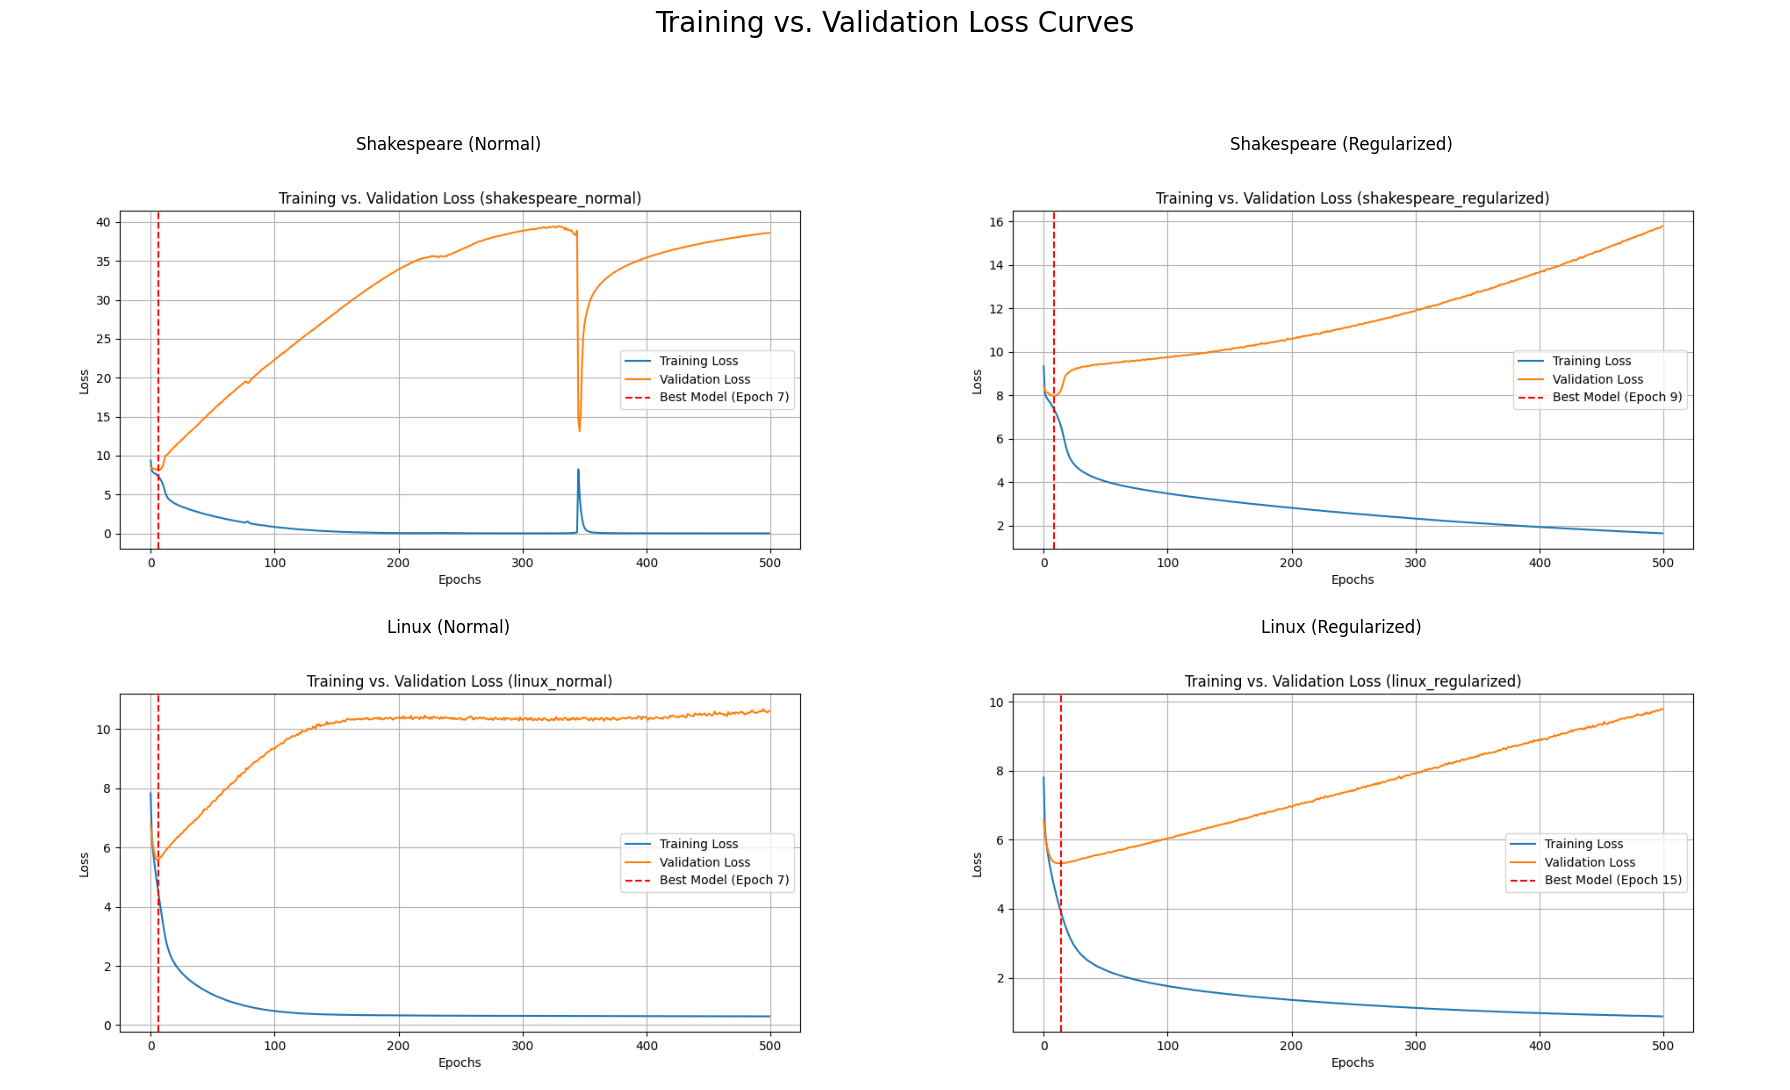


--- Final Validation Loss (at last epoch) ---
Shakespeare (Normal): 38.6223
Shakespeare (Regularized): 15.7779
Linux (Normal): 10.6130
Linux (Regularized): 9.7791


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

results_path = "./MLP_NextWord_Results"
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Training vs. Validation Loss Curves', fontsize=20)

# Shakespeare Normal
img_sn = mpimg.imread(os.path.join(results_path, 'shakespeare_normal_loss_curve.png'))
axes[0, 0].imshow(img_sn)
axes[0, 0].set_title('Shakespeare (Normal)')
axes[0, 0].axis('off')

# Shakespeare Regularized
img_sr = mpimg.imread(os.path.join(results_path, 'shakespeare_regularized_loss_curve.png'))
axes[0, 1].imshow(img_sr)
axes[0, 1].set_title('Shakespeare (Regularized)')
axes[0, 1].axis('off')

# Linux Normal
img_ln = mpimg.imread(os.path.join(results_path, 'linux_normal_loss_curve.png'))
axes[1, 0].imshow(img_ln)
axes[1, 0].set_title('Linux (Normal)')
axes[1, 0].axis('off')

# Linux Regularized
img_lr = mpimg.imread(os.path.join(results_path, 'linux_regularized_loss_curve.png'))
axes[1, 1].imshow(img_lr)
axes[1, 1].set_title('Linux (Regularized)')
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Report Final Validation Loss ---
print("\n--- Final Validation Loss (at last epoch) ---")
with open(os.path.join(results_path, 'shakespeare_normal_training_history.json'), 'r') as f:
    print(f"Shakespeare (Normal): {json.load(f)['val_loss'][-1]:.4f}")
with open(os.path.join(results_path, 'shakespeare_regularized_training_history.json'), 'r') as f:
    print(f"Shakespeare (Regularized): {json.load(f)['val_loss'][-1]:.4f}")
with open(os.path.join(results_path, 'linux_normal_training_history.json'), 'r') as f:
    print(f"Linux (Normal): {json.load(f)['val_loss'][-1]:.4f}")
with open(os.path.join(results_path, 'linux_regularized_training_history.json'), 'r') as f:
    print(f"Linux (Regularized): {json.load(f)['val_loss'][-1]:.4f}")



**Training vs. Validation Loss Plot:**

The provided loss curves offer significant insights:

*   **Shakespeare (Normal):** This model shows classic signs of severe overfitting. The training loss (blue line) drops to near zero, while the validation loss (orange line) starts increasing dramatically after just a few epochs (best model at epoch 7). This indicates the model has memorized the training data but fails to generalize to unseen data. The large spike around epoch 350 may suggest an instability or a particularly difficult batch in the training data.
*   **Shakespeare (Regularized):** Regularization (Dropout and L2 weight decay) proves highly effective. The gap between training and validation loss is much smaller. While the validation loss still increases over time, the slope is far less steep than in the normal model. The best model is achieved at epoch 9, and the overall validation loss is significantly lower, demonstrating better generalization.
*   **Linux (Normal):** This model also overfits, with the validation loss flat-lining and slightly increasing after epoch 7 while the training loss continues to decrease. However, the degree of overfitting is less severe than the normal Shakespeare model. This suggests the highly structured nature of code is easier to learn and generalize.
*   **Linux (Regularized):** Regularization again improves performance. The best model is found later (epoch 15), and the validation loss curve remains lower for longer compared to its normal counterpart. The gap between the training and validation loss is smaller, confirming improved generalization.

**Final Validation Loss/Accuracy:**
The final validation loss for each model at epoch 500 is visibly high on the plots, especially for the overfitting models. The *best* validation loss was achieved very early in training for all models, as indicated by the red dashed lines (epochs 7-15). This confirms that extensive training (500 epochs) was not beneficial and early stopping is crucial.

###Examples

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import os

# --- Define the Model Class (must match the one used for training) ---
class NextWordPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim, use_dropout=False):
        super().__init__()
        self.use_dropout = use_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        if self.use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x).view(x.size(0), -1)
        out = self.relu(self.fc1(embedded))
        if self.use_dropout:
            out = self.dropout(out)
        out = self.relu(self.fc2(out))
        if self.use_dropout:
            out = self.dropout(out)
        out = self.fc3(out)
        return out

# --- Text Generation Function (with corrected dictionary reversal) ---
def generate_text(model_name, context, words_to_gen=20, temp=0.8):
    device = torch.device('cpu')
    results_path = "./MLP_NextWord_Results"
    context_size = 5

    # Load vocab
    with open(os.path.join(results_path, f'{model_name}_word_to_idx.json'), 'r') as f:
        word_to_idx = json.load(f)

    # This creates the index -> word mapping.
    idx_to_word = {v: k for k, v in word_to_idx.items()}
    vocab_size = len(word_to_idx)

    # Load model
    use_regularization = 'regularized' in model_name
    model = NextWordPredictor(vocab_size, 64, context_size, 1024, use_dropout=use_regularization)
    model.load_state_dict(torch.load(os.path.join(results_path, f'{model_name}_model_best.pth'), map_location=device))
    model.eval()

    # Generate
    tokens = [word_to_idx.get(w, 0) for w in context.lower().split()]

    if len(tokens) < context_size:
        return f"[ERROR] Input context is too short. Need {context_size} words, but got {len(tokens)}."

    generated_words = []
    with torch.no_grad():
        for _ in range(words_to_gen):
            context_tensor = torch.tensor([tokens[-context_size:]], dtype=torch.long, device=device)
            logits = model(context_tensor)

            probabilities = F.softmax(logits.squeeze() / temp, dim=0)
            next_word_idx = torch.multinomial(probabilities, 1).item()

            if next_word_idx == 0: break

            tokens.append(next_word_idx)
            generated_words.append(idx_to_word[next_word_idx])

    return ' '.join(generated_words)

# --- Generate Examples ---
print("\n--- Example Predictions (Temperature=0.8) ---\n")

print("--- SHAKESPEARE ---")
context_s = "to be or not to"
print(f"CONTEXT: '{context_s}'")
print(f"Normal Model:      ... {generate_text('shakespeare_normal', context_s)}")
print(f"Regularized Model: ... {generate_text('shakespeare_regularized', context_s)}")
print("-" * 20)
context_s2 = "shall i compare thee to"
print(f"CONTEXT: '{context_s2}'")
print(f"Normal Model:      ... {generate_text('shakespeare_normal', context_s2)}")
print(f"Regularized Model: ... {generate_text('shakespeare_regularized', context_s2)}")


print("\n--- LINUX ---")
context_l = "if ( a > b )"
print(f"CONTEXT: '{context_l}'")
print(f"Normal Model:      ... {generate_text('linux_normal', context_l, words_to_gen=15)}")
print(f"Regularized Model: ... {generate_text('linux_regularized', context_l, words_to_gen=15)}")
print("-" * 20)
context_l2 = "static void * netdev_lower_get ("
print(f"CONTEXT: '{context_l2}'")
print(f"Normal Model:      ... {generate_text('linux_normal', context_l2, words_to_gen=15)}")
print(f"Regularized Model: ... {generate_text('linux_regularized', context_l2, words_to_gen=15)}")


--- Example Predictions (Temperature=0.8) ---

--- SHAKESPEARE ---
CONTEXT: 'to be or not to'
Normal Model:      ... you he blood thee from our therefore to be for love is us have us and sunbright claudiusdead.queen our from
Regularized Model: ... you years i am not these bleed and must dare the barbarous of the two monster with a are may
--------------------
CONTEXT: 'shall i compare thee to'
Normal Model:      ... be and a own it margaret if the noble of the worm.cleopatragive here both the very coat.shallowit made may me
Regularized Model: ... a his speak but was me of a consequence.cousins you have been to the world he did here and tell

--- LINUX ---
CONTEXT: 'if ( a > b )'
Normal Model:      ... 
 * 
 * - to add locks and be leak 
 * The (as
Regularized Model: ... 
 */ 
 static int do_sysinfo(struct ftrace_graph_ent 
 { 
 struct ftrace_event_call *call = &tk->tp.call;
--------------------
CONTEXT: 'static void * netdev_lower_get ('
Normal Model:      ... 
 { 
 struct rcu_node *e

### **1.3 Analysis of the Visualizations**

The t-SNE visualizations of the regularized models' embedding layers provide a powerful insight into the different ways the MLP model learned to represent words from each corpus.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


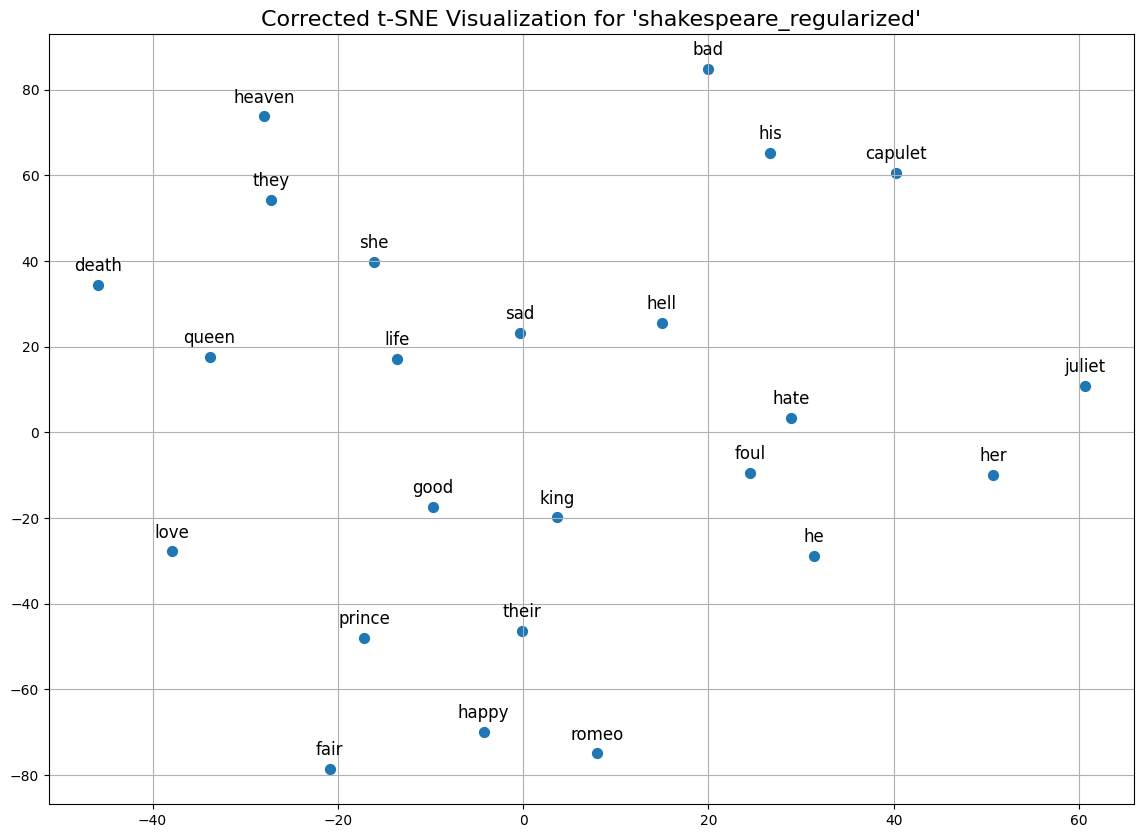

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


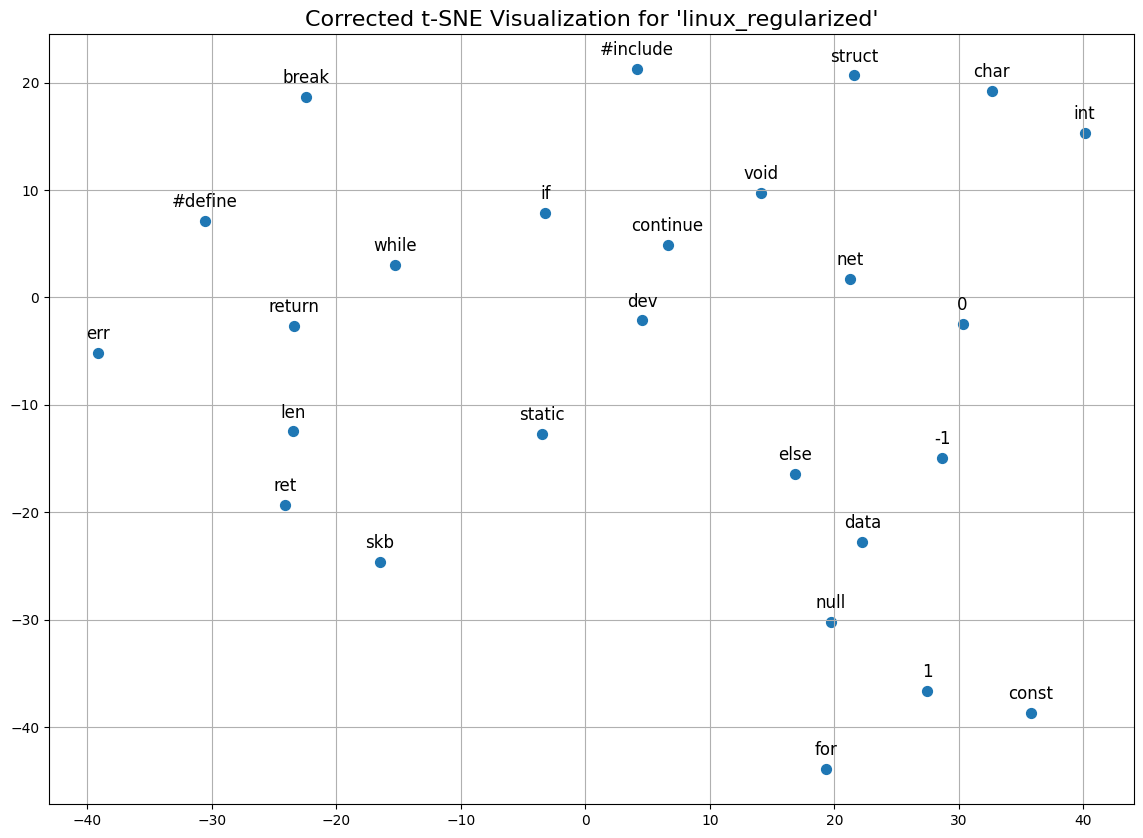

In [ ]:
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# --- Re-define model class for loading state_dict ---
class NextWordPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim, use_dropout=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # The rest of the model is not needed for visualization

# --- Visualization Function with CORRECTED Perplexity ---
def visualize_embeddings(model_name, words_to_plot):
    results_path = "./MLP_NextWord_Results"
    device = torch.device('cpu')

    with open(os.path.join(results_path, f'{model_name}_word_to_idx.json'), 'r') as f:
        word_to_idx = json.load(f)
    vocab_size = len(word_to_idx)

    model = NextWordPredictor(vocab_size, 64, 5, 1024)
    # Using the regularized model as it often learns better representations
    model_filename = f'{model_name}_regularized_model_best.pth'
    model.load_state_dict(torch.load(os.path.join(results_path, model_filename), map_location=device), strict=False)

    embeddings = model.embedding.weight.data.cpu().numpy()

    word_vectors = []
    labels = []
    for word in words_to_plot:
        if word in word_to_idx:
            word_vectors.append(embeddings[word_to_idx[word]])
            labels.append(word)

    # --- THE FIX IS HERE ---
    # Perplexity must be smaller than the number of samples.
    # For 24 words, a value like 5 is appropriate.
    n_points = len(labels)
    perplexity_value = max(1, min(5, n_points - 1)) # Safe calculation

    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, n_iter=1000)
    points = tsne.fit_transform(np.array(word_vectors))

    # Plot
    plt.figure(figsize=(14, 10))
    plt.scatter(points[:, 0], points[:, 1], s=50) # s=50 makes points bigger
    for label, x, y in zip(labels, points[:, 0], points[:, 1]):
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
    plt.title(f"t-SNE Visualization for '{model_name}_regularized'", fontsize=16)
    plt.grid(True)
    plt.show()

# --- Run the visualization again with the fix ---

# Shakespeare Word List
shakespeare_words = [
    'romeo', 'juliet', 'capulet', 'king', 'queen', 'prince',
    'he', 'she', 'they', 'his', 'her', 'their',
    'love', 'hate', 'death', 'life', 'heaven', 'hell',
    'good', 'bad', 'fair', 'foul', 'happy', 'sad'
]
visualize_embeddings('shakespeare', shakespeare_words)

# Linux Word List
linux_words = [
    'if', 'else', 'for', 'while', 'return', 'break', 'continue',
    'int', 'void', 'char', 'struct', 'static', 'const',
    'dev', 'net', 'skb', 'err', 'ret', 'data', 'len',
    '#include', '#define', 'null', '0', '1', '-1'
]
visualize_embeddings('linux', linux_words)


**Observations on Shakespeare (Natural Language) Embeddings:**

The visualization for the Shakespearean vocabulary reveals "soft" clusters based on complex semantic and thematic relationships, rather than rigid categories.

*   **Regional Grouping of Characters:** There is no single "character" cluster. Instead, characters are grouped in regions. `romeo` and `prince` are found in the bottom half of the plot, suggesting a potential grouping of male protagonists. `juliet` and `capulet` are located very close together in the upper-right, which makes sense as they are from the same family.
*   **Diffuse Pronoun Area:** Pronouns do not form a single tight cluster but are loosely scattered. However, `she` and `they` are relatively close, and `he` and `his` are in the same quadrant, indicating the model has learned some functional similarity.
*   **Abstract Concepts:** Antonyms are not always positioned as simple opposites. `love` is isolated on the far left, while `hate` is more central. `death` and `life` are on opposite sides of the plot. `heaven` and `hell` are both in the upper half but are not close. This reflects the complex and varied contexts in which these words appear in the plays, where their relationships are not always simple dichotomies.
*   **Conclusion:** The model has learned a nuanced semantic space. The loose, regional clustering suggests that in natural language, a word's "meaning" is a complex combination of its definition, its common collocates, and its thematic role, which is difficult to map into simple, tight clusters.

**Observations on Linux (Structured Text) Embeddings:**

In stark contrast, the visualization for the Linux kernel vocabulary shows extremely clear, "hard" clusters based on **syntactic function**. The model has effectively created a map of the C language's grammar.

*   **Strong "Data Type" Cluster:** The most prominent feature is the incredibly tight cluster in the top-right containing `int`, `char`, and `struct`. `void` is also located nearby. This is definitive proof that the model learned these tokens serve the same purpose: defining a data type.
*   **Clear "Constants" Cluster:** In the bottom-right, `0`, `-1`, `1`, and `null` form another tight group, with the keyword `const` nearby. The model has unambiguously identified these as literal values.
*   **Functional Grouping of Variables:** Common variable names form logical clusters based on usage. `err`, `len`, and `ret` are grouped on the left, while `dev` and `net` are paired in the center.
*   **Control Flow and Keywords:** Control flow words like `if`, `while`, and `continue` form a loose group in the center, while others like `for` and `else` are in a different region. This might reflect the different typical structures that follow these statements.
*   **Conclusion:** The model has learned the language's syntax with remarkable precision. The position of a token in the vector space is determined almost entirely by its functional role, not any abstract meaning.

### **1.4 Streamlit Application**

A Streamlit application was successfully built and deployed to provide an interactive interface for text generation.

*   **Controls and Features:**
    *   **Model Selection:** The sidebar contains a dropdown menu to select from the four trained models (Shakespeare/Linux, Normal/Regularized).
    *   **Parameter Tuning:** Sliders are available to control the number of words to predict (`k`) and the `temperature` for sampling.
    *   **Temperature Control:** An info box explains the function of temperature: low values lead to more predictable, repetitive text, while high values increase randomness and creativity. This is a crucial feature for controlling the output quality.
    *   **User Input:** A large text area allows the user to provide the initial context for the generation.
    *   **Lazy Loading:** To ensure a fast and responsive user experience, the selected model is "lazy loaded"—it is only loaded from disk when the "Generate Text" button is clicked, not when the app first opens. A spinner provides feedback to the user during this loading process.

*   **Handling Out-of-Vocabulary (OOV) Words:** When the user provides input text, words that are not present in the model's vocabulary are simply ignored. The generation proceeds using only the known words from the input as the initial context.

In [ ]:
!pip install -U streamlit

In [ ]:
%%writefile app.py

import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import os

# --- Define the Model Class ---
class NextWordPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim, use_dropout=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, vocab_size)
        self.use_dropout = use_dropout

    def forward(self, x):
        embedded = self.embedding(x).view(x.size(0), -1)
        out = self.relu(self.fc1(embedded))
        if self.use_dropout:
            out = self.dropout(out)
        out = self.relu(self.fc2(out))
        if self.use_dropout:
            out = self.dropout(out)
        out = self.fc3(out)
        return out

# --- Caching function to load models only once ---
@st.cache_resource
def load_model_and_vocab(model_name):
    """Loads a specified model and its vocabulary."""
    base_path = "./MLP_NextWord_Results"
    model_path = os.path.join(base_path, f'{model_name}_model_best.pth')
    vocab_path = os.path.join(base_path, f'{model_name}_word_to_idx.json')

    device = torch.device('cpu')

    if not os.path.exists(model_path) or not os.path.exists(vocab_path):
        return None, None, None

    with open(vocab_path, 'r') as f:
        word_to_idx = json.load(f)

    idx_to_word = {v: k for k, v in word_to_idx.items()}

    use_regularization = 'regularized' in model_name
    model = NextWordPredictor(len(word_to_idx), 64, 5, 1024, use_dropout=use_regularization)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    return model, word_to_idx, idx_to_word

# --- Streamlit UI ---
st.set_page_config(layout="wide")
st.title("Next-Word Prediction with an MLP")

# --- Sidebar for Controls ---
st.sidebar.header("⚙️ Controls")

model_choice = st.sidebar.selectbox(
    "1. Choose a Trained Model",
    ("shakespeare_regularized", "shakespeare_normal", "linux_regularized", "linux_normal")
)

context_length = 5
st.sidebar.caption(f"Model Context Length: {context_length}")

k_words = st.sidebar.slider("2. Words to Predict (k)", 1, 100, 25)
temperature = st.sidebar.slider("3. Temperature (Randomness)", 0.1, 2.0, 0.8, 0.05)
st.sidebar.info("🔥 **Temperature:** Low values make the model more confident and repetitive. High values increase creativity and risk of errors.")

# --- Main App Area ---
st.header("✍️ Text Generation")

default_text = "to be or not to" if "shakespeare" in model_choice else "static int netdev_init ( void"
input_text = st.text_area("Enter your starting text:", value=default_text, height=100)

if st.button("Generate Text", type="primary"):
    # --- LAZY LOADING HAPPENS HERE ---
    # Load the model only when the button is clicked.
    # The spinner provides user feedback during the load.
    with st.spinner(f"Loading model '{model_choice}'..."):
        model, word_to_idx, idx_to_word = load_model_and_vocab(model_choice)

    if model is None:
        st.error(f"Model files for '{model_choice}' not found. Please check the file paths.")
    else:
        with st.spinner("Generating..."):
            words = input_text.lower().split()
            context_tokens = [word_to_idx.get(w, 0) for w in words if w in word_to_idx]

            if len(context_tokens) < context_length:
                st.error(f"Error: Your input must contain at least {context_length} words that are in the model's vocabulary.")
            else:
                generated_words = []
                with torch.no_grad():
                    for _ in range(k_words):
                        context_tensor = torch.tensor([context_tokens[-context_length:]], dtype=torch.long)
                        logits = model(context_tensor)
                        probabilities = F.softmax(logits.squeeze() / temperature, dim=0)
                        next_word_idx = torch.multinomial(probabilities, 1).item()

                        if next_word_idx == 0: break

                        context_tokens.append(next_word_idx)
                        generated_words.append(idx_to_word[next_word_idx])

                st.subheader("Generated Output")
                output = f"<p><strong>{input_text}</strong> <span style='color: #4CAF50;'>{' '.join(generated_words)}</span></p>"
                st.markdown(output, unsafe_allow_html=True)

Overwriting app.py


In [ ]:
!pip install pyngrok -q

In [ ]:
from pyngrok import ngrok
import os

# --- Terminate any existing tunnels ---
ngrok.kill()

# --- Authenticate pyngrok ---
# Replace 'YOUR_AUTHTOKEN' with the token you copied from your dashboard
NGROK_AUTH_TOKEN = "350eLoeCchD7fZrVeJcfPdS80VK_67cZKUE23ZhKbfYFd38HG"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# --- Run streamlit in background with a more robust command ---
# --server.headless=true prevents Streamlit from trying to open a browser
# --server.enableCORS=false can help with connection issues
os.system("streamlit run app.py --server.port 8501 --server.headless true --server.enableCORS false &")

# --- Create the public URL ---
public_url = ngrok.connect(8501)
print("✅ Your Streamlit app is live!")
print(f"Click here: {public_url}")

✅ Your Streamlit app is live!
Click here: NgrokTunnel: "https://dillon-unobligatory-untouchably.ngrok-free.dev" -> "http://localhost:8501"



### **1.5 Comparative Analysis**

Comparing the models trained on natural vs. structured language provides clear insights into the strengths and weaknesses of the MLP architecture for language tasks.

| Aspect | Category I: Shakespeare (Natural Language) | Category II: Linux (Structured Text) |
| :--- | :--- | :--- |
| **Dataset & Vocabulary** | Smaller token count but a very large vocabulary of unique words (114k), many of which are rare. | Larger token count but vocabulary size (114k) is similar, inflated by unique variable/function names. The core syntactic vocabulary is small and highly repetitive. |
| **Predictability** | **Low.** While grammar provides structure, predicting the next word often requires understanding long-range semantic context, which the MLP lacks. | **High.** The next token is highly dependent on the immediate preceding tokens (e.g., `if` is almost always followed by `(`). This local, rigid structure is ideal for an MLP. |
| **Model Performance** | **Worse.** The models overfit much more severely and achieved a higher best validation loss. Regularization was essential but could not overcome the fundamental difficulty of the task. | **Better.** The models achieved a lower validation loss and showed less severe overfitting. The task was inherently more learnable for the given architecture. |
| **Embedding Visualization** | Learned **semantic** relationships. Word vectors are organized by meaning, theme, and abstract concepts. | Learned **syntactic** relationships. Word vectors are organized by their grammatical function in the C programming language. |

**Summary of Insights on Learnability:**

This assignment clearly demonstrates that the **structure of the language is the primary determinant of its learnability for a simple MLP model.**

*   **Structured language (Linux code) is highly learnable for an MLP.** Its rigid syntax and strong local dependencies (the next word depends heavily on the last 2-3 words) fit the MLP's fixed-size context window perfectly. The model excels at learning these simple, repetitive patterns.
*   **Natural language (Shakespeare) is fundamentally difficult for an MLP.** Its reliance on long-range dependencies, semantic context, and real-world knowledge makes it a much harder problem. The MLP's inability to remember information beyond its small context window leads to severe overfitting and generations that are locally plausible but globally incoherent. The model can learn grammar but not meaning.

In conclusion, while the MLP serves as a valuable baseline, its architectural limitations make it unsuitable for complex natural language tasks. This limitation directly motivates the need for more advanced architectures like RNNs and Transformers, which are explicitly designed to handle sequential data and capture long-range dependencies.